In [26]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from scipy.ndimage import gaussian_filter


In [27]:
def create_grid(Nx, Ny, Lx, Ly):
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    X, Y = np.meshgrid(x, y)
    return X, Y, dx, dy

In [28]:
def apply_phi_BCs(phi):
    """
    Apply periodic boundary conditions to phi (3-cell periodic BCs).
    """
    phi[0:3, :] = phi[-6:-3, :]
    phi[-3:, :] = phi[3:6, :]
    phi[:, 0:3] = phi[:, -6:-3]
    phi[:, -3:] = phi[:, 3:6]
    
    # phi[0, :] = phi[1, :]
    # phi[-1, :] = phi[-2, :]
    # phi[:, 0] = phi[:, 1]
    # phi[:, -1] = phi[:, -2]
    return phi

def reinitialize_phi_PDE(phi_in, dx, dy, num_iters, apply_phi_BCs_func, dt_reinit_factor=0.5):
    """
    Reinitializes phi to be a signed distance function using a PDE-based method.
    Solves: phi_tau + S(phi_initial) * ( |grad(phi)| - 1 ) = 0
    
    Args:
        phi_in (np.ndarray): The level set function to reinitialize. This phi is assumed
                             to correctly define the interface (phi_in=0), but may not be
                             an SDF away from it.
        dx (float): Grid spacing in x.
        dy (float): Grid spacing in y.
        num_iters (int): Number of pseudo-time iterations for the reinitialization PDE.
                         Typically 5-10 iterations are sufficient.
        apply_phi_BCs_func (callable): Function to apply boundary conditions to phi.
                                       This function will be called after each iteration.
                                       Example: `apply_phi_BCs` from your existing code.
        dt_reinit_factor (float): Factor to determine the pseudo-timestep for reinitialization.
                                  dt_reinit = dt_reinit_factor * min(dx, dy).
                                  For stability with this explicit upwind scheme, this
                                  factor should generally be <= 1.0. A value of 0.5 is common.
    
    Returns:
        np.ndarray: The reinitialized level set function.
    """
    phi = phi_in.copy()
    
    # S(phi_initial): Determine the sign of the initial phi field.
    # np.sign(0) is 0, which correctly identifies interface points.
    # phi_initial_sign = np.sign(phi_in)
    
    phi_initial_sign = phi_in / np.sqrt(phi_in**2 + dx**2)  # Avoid division by zero, ensure no NaNs.

    # Pseudo-timestep for the reinitialization PDE
    dt_reinit = dt_reinit_factor * min(dx, dy)

    for _ in range(num_iters):
        # Pad phi to handle boundaries when computing finite differences.
        # 'edge' mode replicates border values, a common approach if specific ghost cell
        # values based on complex BCs are not set up prior to gradient calculation.
        phi_padded = np.pad(phi, 1, mode='edge') 
        
        # Calculate forward and backward differences from the padded array.
        # These correspond to differences on the original grid dimensions.
        # Dx_m[j,i] = (phi[j,i] - phi[j,i-1])/dx  (Backward difference in x at point i,j)
        # Dx_p[j,i] = (phi[j,i+1] - phi[j,i])/dx  (Forward difference in x at point i,j)
        # Dy_m[j,i] = (phi[j,i] - phi[j-1,i])/dy  (Backward difference in y at point i,j)
        # Dy_p[j,i] = (phi[j,i+1] - phi[j,i])/dy  (Forward difference in y at point i,j)
        
        Dx_m = (phi_padded[1:-1, 1:-1] - phi_padded[1:-1, 0:-2]) / dx
        Dx_p = (phi_padded[1:-1, 2:]   - phi_padded[1:-1, 1:-1]) / dx
        Dy_m = (phi_padded[1:-1, 1:-1] - phi_padded[0:-2, 1:-1]) / dy
        Dy_p = (phi_padded[2:,   1:-1] - phi_padded[1:-1, 1:-1]) / dy

        # Calculate upwinded squared gradients based on S(phi_initial)
        # These are (phi_x)^2 and (phi_y)^2 in the PDE, chosen with upwinding
        # to ensure information propagates from the interface.
        grad_phi_x_sq = np.zeros_like(phi)
        grad_phi_y_sq = np.zeros_like(phi)

        # --- Upwind scheme based on Sussman, Smereka, Osher (1994) ---
        # Mask for S(phi_initial) > 0 (points outside the solid, phi should be positive)
        mask_pos = (phi_initial_sign > 0)
        grad_phi_x_sq[mask_pos] = np.maximum( np.maximum(Dx_m[mask_pos], 0.)**2,  np.minimum(Dx_p[mask_pos], 0.)**2 )
        grad_phi_y_sq[mask_pos] = np.maximum( np.maximum(Dy_m[mask_pos], 0.)**2,  np.minimum(Dy_p[mask_pos], 0.)**2 )

        # Mask for S(phi_initial) < 0 (points inside the solid, phi should be negative)
        mask_neg = (phi_initial_sign < 0)
        grad_phi_x_sq[mask_neg] = np.maximum( np.minimum(Dx_m[mask_neg], 0.)**2,  np.maximum(Dx_p[mask_neg], 0.)**2 )
        grad_phi_y_sq[mask_neg] = np.maximum( np.minimum(Dy_m[mask_neg], 0.)**2,  np.maximum(Dy_p[mask_neg], 0.)**2 )
        
        # For S(phi_initial) == 0 (interface points themselves):
        # grad_phi_x_sq and grad_phi_y_sq remain 0 at these points.
        # This means grad_phi_mag will be 0 for these points.
        # The update term S(phi_initial) * (grad_phi_mag - 1) becomes 0 * (0 - 1) = 0.
        # Thus, interface points (where phi_initial_sign == 0) are kept fixed during reinitialization.
        # This is a desired behavior.

        grad_phi_mag = np.sqrt(grad_phi_x_sq + grad_phi_y_sq)
        
        # PDE term: S(phi_initial) * ( |grad(phi)| - 1 )
        dphi_dtau = phi_initial_sign * (grad_phi_mag - 1.0)
        
        # Update phi using Forward Euler in pseudo-time tau
        phi = phi - dt_reinit * dphi_dtau
        
        # Apply the user-specified physical boundary conditions for phi after each iteration.
        # This is important as the reinitialization PDE itself doesn't know about these BCs,
        # and the 'edge' padding is a generic numerical BC for derivatives.
        if apply_phi_BCs_func:
            phi = apply_phi_BCs_func(phi) # e.g., call your apply_phi_BCs(phi)
            
    return phi

In [29]:
with h5py.File("frames/data_000001.h5", "r") as f:
    phi00 = f["phi"][:]
    
with h5py.File("frames/data_015300.h5", "r") as f:
    phi0 = f["phi"][:]
    sigma_xx0 = f["sigma_xx"][:]
    sigma_xy0 = f["sigma_xy"][:]
    sigma_yy0 = f["sigma_yy"][:]
    X10 = f["X1"][:]
    X20 = f["X2"][:]
    J0 = f["J"][:]
    a0 = f["a"][:]
    b0 = f["b"][:]
    p0 = f["p"][:]
    div_vel0 = f["div_vel"][:]
    

with h5py.File("frames/data_164000.h5", "r") as f:
    phi = f["phi"][:]
    sigma_xx = f["sigma_xx"][:]
    sigma_xy = f["sigma_xy"][:]
    sigma_yy = f["sigma_yy"][:]
    X1 = f["X1"][:]
    X2 = f["X2"][:]
    J = f["J"][:]
    a = f["a"][:]
    b = f["b"][:]
    p = f["p"][:]
    div_vel = f["div_vel"][:]


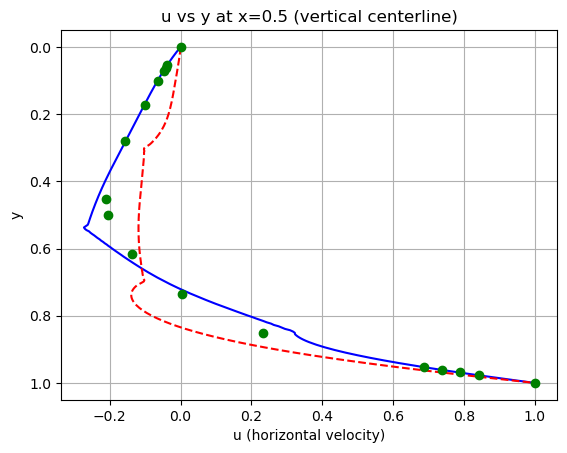

In [30]:
# plot the benchmark at cavity center line
Ny0 = Nx0 = 256
Ny = Nx = 256
y0 = np.linspace(0, 1, Ny0)
y = np.linspace(0, 1, Ny)

# a = gaussian_filter(a, sigma=1)
# a0 = gaussian_filter(a0, sigma=1)
u_center_x = a[:, Nx // 2]  # u_x at center vertical line
u_center_x0 = a0[:, Nx0 // 2]  # u_x at center vertical line

# load plot_u_y_Ghia100.csv first column y and second column u
u_ghia = np.loadtxt("plot_u_y_Ghia100.csv", delimiter=",", skiprows=1)
y_ghia = u_ghia[:, 0]
u_ghia = u_ghia[:, 1]
# plot the benchmark at cavity center line



plt.figure()
plt.plot(u_center_x, y, 'b')
plt.plot(u_center_x0, y0, "r--")
plt.plot(u_ghia, y_ghia, "og", label="Ghia et al. (1982)")
plt.xlabel("u (horizontal velocity)")
plt.ylabel("y")
plt.title("u vs y at x=0.5 (vertical centerline)")
plt.grid(True)
plt.gca().invert_yaxis()  # optional to match standard benchmark view
plt.show()

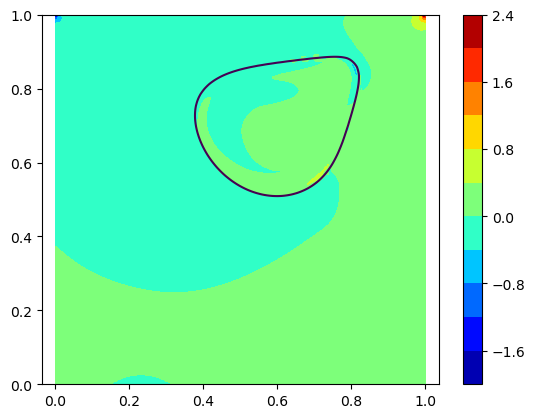

In [31]:

Lx, Ly = 1.0, 1.0
X, Y, dx, dy = create_grid(Nx, Ny, Lx, Ly)

Lx, Ly = 1.0, 1.0
X0, Y0, dx0, dy0 = create_grid(Nx0, Ny0, Lx, Ly)

# phi = reinitialize_phi_PDE(phi, dx, dy, num_iters=20, apply_phi_BCs_func=None)

dpdx, dpdy = np.gradient(p0, dx, dy)


plt.contourf(X, Y, p, levels=10, cmap="jet")
plt.colorbar()
plt.contour(X,Y, phi, levels=[0])
plt.axis('equal')
plt.show()

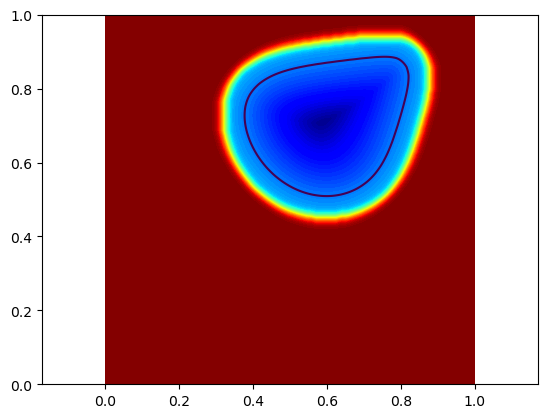

In [32]:
phi = reinitialize_phi_PDE(phi, dx, dy, num_iters=200, apply_phi_BCs_func=None, dt_reinit_factor=0.01)
plt.contourf(X, Y, phi, levels=100, cmap="jet")
plt.contour(X,Y, phi, levels=[0])
plt.axis('equal')
plt.show()

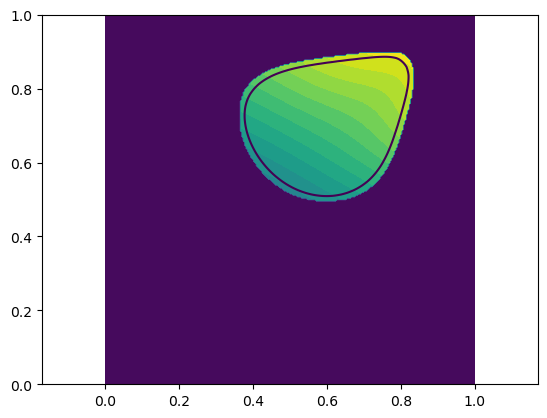

In [33]:
plt.contourf(X, Y, X1, levels=20)
plt.contour(X, Y, phi, levels=[0])
plt.axis('equal')
plt.show()

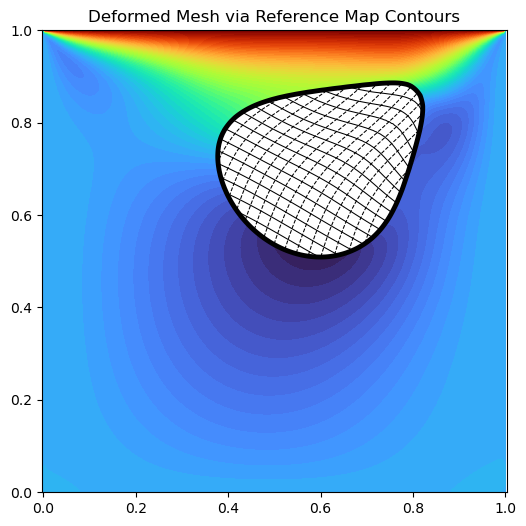

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Mask the region where phi <= 0 (solid) to make it white
a_masked = np.ma.masked_where(phi <= 0, a)

plt.figure(figsize=(6, 6))
plt.contourf(X, Y, a_masked, levels=70, cmap="turbo")

# Overlay a white patch over the solid region (optional for clean white fill)
plt.contourf(X, Y, phi <= 0, levels=[0.5, 1], colors='white', zorder=2)

# Add reference map contours
X1_masked = np.where(phi <= 0, X1, np.nan)
X2_masked = np.where(phi <= 0, X2, np.nan)
plt.contour(X, Y, phi, levels=[0], colors='black', linewidths=3.5, zorder=3)
plt.contour(X, Y, X1_masked, levels=15, colors='black', linewidths=0.75, linestyles='solid', zorder=4)
plt.contour(X, Y, X2_masked, levels=15, colors='black', linewidths=0.75, linestyles='dashed', zorder=4)

plt.title("Deformed Mesh via Reference Map Contours")
plt.axis('equal')
plt.show()



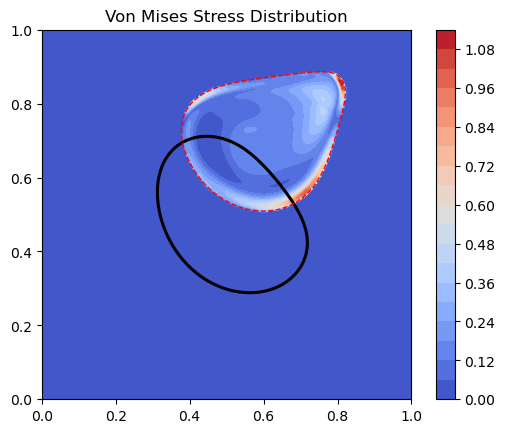

In [35]:
# smooth out the data
solid_mask = phi <= 0
sigma_vmises = np.sqrt(sigma_xx**2 - sigma_xx*sigma_yy + sigma_yy**2 + 3*sigma_xy**2)
# sigma_vmises = gaussian_filter(sigma_vmises, sigma=0.1)

sigma_vmises0 = np.sqrt(sigma_xx0**2 - sigma_xx0*sigma_yy0 + sigma_yy0**2 + 3*sigma_xy0**2)
# sigma_vmises0 = gaussian_filter(sigma_vmises0, sigma=0.1)
plt.contourf(X,Y, sigma_vmises, levels=20, cmap="coolwarm")
plt.colorbar()

plt.contour(X0, Y0, phi0, levels=[0], colors='black', linewidths=2.2, linestyles='-')
plt.contour(X,  Y, phi, levels=[0], colors='red', linewidths=1., linestyles='--')
plt.gca().set_aspect('equal')

plt.title("Von Mises Stress Distribution")
plt.show()


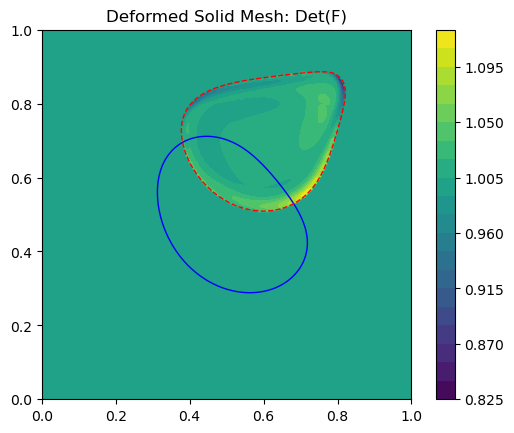

In [36]:
# J = gaussian_filter(J, sigma=1)
# plt.contour(X0, Y0, phi00, levels=[0], colors='black', linewidths=0.5)
plt.contour(X0, Y0, phi0, levels=[0], colors='b', linewidths=1, linestyles='-')
plt.contour(X, Y, phi, levels=[0], colors='r', linewidths=1, linestyles='--')
solid_mask = phi <= 0
plt.contourf(X,Y, J, levels=20)
plt.colorbar()
plt.gca().set_aspect('equal')

plt.title("Deformed Solid Mesh: Det(F)")
plt.show()


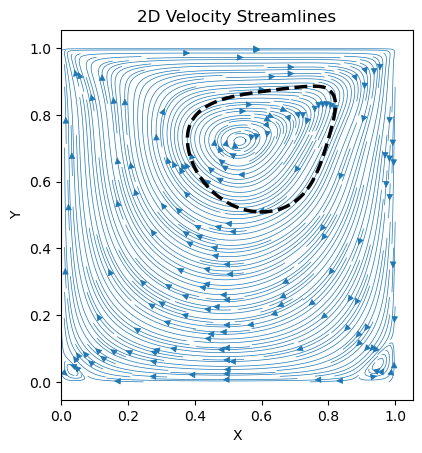

In [37]:
# Create Meshgrid for 3D surface plot
Lx, Ly = 1.0, 1.0
X, Y, dx, dy = create_grid(Nx, Ny, Lx, Ly)

# plot 2D velocity streamlines
fig, ax = plt.subplots()
ax.streamplot(X, Y, a, b, linewidth=0.5, density=3.5)
ax.set_title('2D Velocity Streamlines')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.gca().set_aspect('equal')

ax.contour(X, Y, phi, levels=[0], colors='black', linewidths=2.5, linestyles='--')
plt.show()

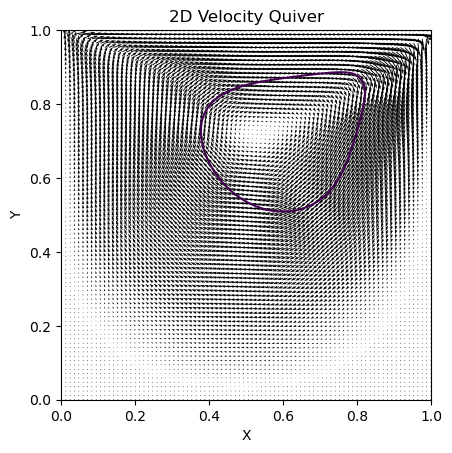

In [38]:
# plot 2D velocity quiver
fig, ax = plt.subplots()
ax.quiver(X[::3, ::3], Y[::3, ::3], a[::3, ::3], b[::3, ::3], angles='xy', scale_units='xy', scale=10.5, color='k')
ax.set_title('2D Velocity Quiver')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.gca().set_aspect('equal')
plt.contour(X, Y, phi, levels=[0])
plt.show()
